In [1]:
import sys
import numpy as np
from scipy.stats import multivariate_normal
import signal
import torch
import re
import pandas as pd
from torch.distributions.multivariate_normal import MultivariateNormal
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, '../SOGA-main/src')
from sogaPreprocessor import *
from producecfg import *
from libSOGA import *

torch.set_default_dtype(torch.float64)
from fitness.soga_fitness_trueskills import *
from algorithm.parameters import params
import utils

In [ ]:
model_name = 'if_sketch3_30'
program_name = 'if'

In [3]:
from os import getcwd, listdir, path, sep

avg_fitness_5000, text_bf = utils.read_fitness_and_program(model_name)
print('Average fitness of best found program on 5000 data: ', np.nanmean(avg_fitness_5000))

fitness_bf = likelihood_of_program_wrt_data(text_bf, program=program_name, data_size=5000)
path_baseline = path.join(getcwd(), "..", "baselines", program_name + ".soga")
file = open(path_baseline)
text_baseline = ''
for line in file.readlines():
    text_baseline += line + ' '
#text_baseline = 'mu = gm([1, 20, 3]);\nsigma = gm([1,2,1]);\nx = sigma * gm([1,1,1]);\nx = x + mu;'

text_bf = 'a = 1  * gm([22.8, 1, 2.1], [1, 10.5, 20.1]); \nif 13 * uniform([28, 7], 4) < 27 { \nb = 30 + b; \n} else { \nb = 12  - gm([16, 3, 2], [30.4, 3, 2.3], [0.4, 20, 18.6], [19.4, 14.3, 3.1]); \n} end if;'
fitness_bl = likelihood_of_program_wrt_data(text_baseline, program=program_name, data_size=5000)

print('Fitness of best found program: ', fitness_bf)
print('Fitness of baseline: ', fitness_bl)
print(text_bf) 

Average fitness of best found program on 5000 data:  -3.7763710031718674
Fitness of best found program:  -3.7018164107166465
Fitness of baseline:  -3.696300784743806
a = 1  * gm([22.8, 1, 2.1], [1, 10.5, 20.1]); 
if 13 * uniform([28, 7], 4) < 27 { 
b = 30 + b; 
} else { 
b = 12  - gm([16, 3, 2], [30.4, 3, 2.3], [0.4, 20, 18.6], [19.4, 14.3, 3.1]); 
} end if;


In [4]:
# Computes SOGA distributions for best found and baseline

soga_bf = preprocess_program(text_bf)
compiledText=compile2SOGA_text(soga_bf)
cfg = produce_cfg_text(compiledText)
output_dist = start_SOGA(cfg)

soga_baseline = preprocess_program(text_baseline)
compiledText_baseline=compile2SOGA_text(soga_baseline)
cfg_baseline = produce_cfg_text(compiledText_baseline)
output_dist_baseline = start_SOGA(cfg_baseline)

In [5]:
# Generates data from original data generating process 

from fitness import data_generating_process as dgp  

data = dgp.generate_dataset(program_name, 5000)
data_var_list, dependencies, weights = dgp.get_vars(program_name)

In [ ]:
import itertools
#take a subset of 500 points from data
data_subset = [data[i] for i in range(500)]
df = pd.DataFrame(data_subset, columns=['a', 'b'])
df.to_csv('dataset_subset.tsv', sep="\t", index=False) 

In [ ]:
def get_mixture_pdf(point, var, dist):
    pdf = 0
    #indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        #for element, index_list in indexes.items():
        marginal_means.append(dist.gm.mu[i][dist.var_list.index(var)])
        covariance_index.append(dist.var_list.index(var))

        marginal_covariance_matrix = dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        
        pdf+= dist.gm.pi[i] * multivariate_normal.pdf(point, mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)
        # print the simbolic expression of the pdf
        print(dist.gm.pi[i],'* N(', marginal_means, ', ', marginal_covariance_matrix, ')')
        


    return pdf
        

/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_38100/4212127798.py:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('viridis', len(data_var_list))


2.468182534895145e-05 * N( [1.0] ,  [[4.41]] )
1.082541397589407e-06 * N( [10.5] ,  [[404.01]] )
0.05787824140927299 * N( [1.0] ,  [[4.41]] )
0.10996870657183229 * N( [1.0] ,  [[4.41]] )
0.001446884193911372 * N( [1.0] ,  [[4.41]] )
0.070177235999656 * N( [1.0] ,  [[4.41]] )
0.05788420680898435 * N( [1.0] ,  [[4.41]] )
0.10998004083622026 * N( [1.0] ,  [[4.41]] )
0.0014470333214996087 * N( [1.0] ,  [[4.41]] )
0.07018446903323103 * N( [1.0] ,  [[4.41]] )
0.057884206809005224 * N( [1.0] ,  [[4.41]] )
0.10998004083625991 * N( [1.0] ,  [[4.41]] )
0.0014470333215001305 * N( [1.0] ,  [[4.41]] )
0.07018446903325633 * N( [1.0] ,  [[4.41]] )
0.057884206809005224 * N( [1.0] ,  [[4.41]] )
0.10998004083625991 * N( [1.0] ,  [[4.41]] )
0.0014470333215001305 * N( [1.0] ,  [[4.41]] )
0.07018446903325633 * N( [1.0] ,  [[4.41]] )
0.0025385315494047627 * N( [10.5] ,  [[404.01]] )
0.004823212044502541 * N( [10.5] ,  [[404.01]] )
6.346013778488149e-05 * N( [10.5] ,  [[404.01]] )
0.003077963726911173 * N( [

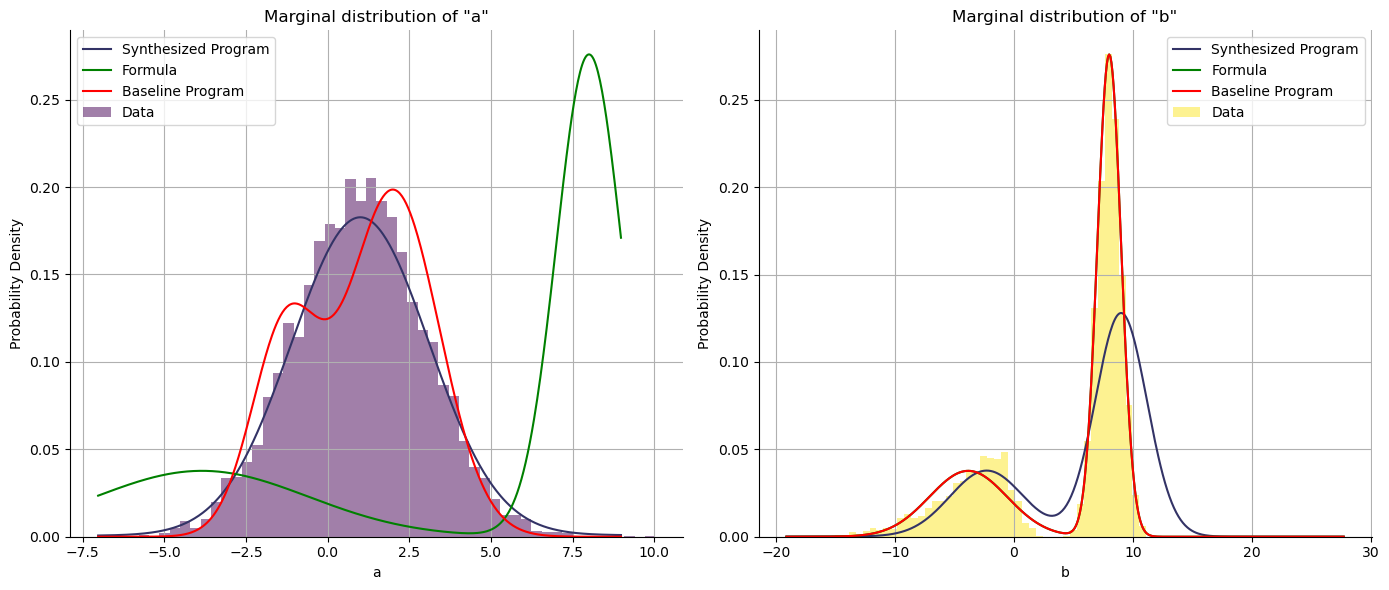

In [8]:
import matplotlib
#matplotlib.use('TkAgg') 

import matplotlib.pyplot as plt
import numpy as np
import torch
import matplotlib.cm as cm


# Define the range for the uniform distribution
x = np.linspace(-10, 10, 500)
x = torch.tensor(x)

# Assuming data_var_list is defined
#data_var_list = ['a', 'b']  # Example list, replace with your actual list
colormap = cm.get_cmap('viridis', len(data_var_list))
colors = [colormap(i) for i in range(len(data_var_list))]

def plot_marginal_distribution(data, data_var_list, dist, colors=colors, baseline=None):

    # Create a figure with subplots
    fig, axs = plt.subplots(1, len(data_var_list), figsize=(14, 6))

    # If there's only one element in data_var_list, axs will not be an array, so we need to handle that case
    if len(data_var_list) == 1:
        axs = [axs]

    # Loop through each element in data_var_list and create a subplot
    for i, var in enumerate(data_var_list):
        color = colors[i]
        # select the x axis
        mean = np.mean([pair[i] for pair in data])
        std = np.std([pair[i] for pair in data])
        x = np.linspace(mean-4*std, mean+4*std, 500)
        x = torch.tensor(x)
        # plots
        axs[i].plot(x, [get_mixture_pdf([xi], var, dist) for xi in x], label='Synthesized Program', color='#333366') 
        axs[i].plot(x, [0.3085375387259869 * 1/(np.sqrt(10.66529466*2*np.pi)) * np.exp(-(xi+3.84646662)**2/(2*10.66529466)) + 0.6914624612740131 * 1/(np.sqrt(1*2*np.pi)) * np.exp(-(xi-8.)**2/(2*1))   for xi in x], label='Formula', color='green')
        if baseline:
            axs[i].plot(x, [get_mixture_pdf([xi], var, baseline) for xi in x], label='Baseline Program', color='red')  
        axs[i].hist([pair[i] for pair in data], bins=50, density=True, alpha=0.5, color=color, label='Data')
        axs[i].set_title(f'Marginal distribution of "{var}"')
        axs[i].set_xlabel(f"{var}")
        axs[i].set_ylabel("Probability Density")
        axs[i].spines['right'].set_visible(False)
        axs[i].spines['top'].set_visible(False)
        axs[i].grid(True)
        axs[i].legend()

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

plot_marginal_distribution(data, data_var_list, output_dist, baseline=output_dist_baseline)

In [9]:

print(output_dist.gm.pi[0])
print(output_dist.gm.mu[0])
print(output_dist.gm.sigma[0])
print(output_dist.gm.pi[1])
print(output_dist.gm.mu[1])
print(output_dist.gm.sigma[1])
#print(output_dist.gm.pi[2])
#print(output_dist.gm.mu[2])
#print(output_dist.gm.sigma[2])
x = 0

#y = 1/(output_dist.gm.sigma[0][0][0]*np.sqrt(2*np.pi)) * np.exp(-(x-output_dist.gm.mu[0][0])**2/(2*output_dist.gm.sigma[0][0][0]**2)) 

#y = 1/(np.sqrt(3.24*2*np.pi)) * np.exp(-(x-1)**2/(2*3.24))
#y = 0.220729 * 1/(np.sqrt(5.589956*2*np.pi)) * np.exp(-(x-9.5)**2/(2*5.589956)) + 0.220729 * 1/(np.sqrt(4.359956*2*np.pi)) * np.exp(-(x+2.1)**2/(2*4.359956)) + 0.558541 * 1/(np.sqrt(0.749956*2*np.pi)) * np.exp(-(x-7.7)**2/(2*0.749956)) 
#y = 0.3085375387259869 * 1/(np.sqrt(1.07392163*2*np.pi)) * np.exp(-(x+1.28215554)**2/(2*1.07392163)) + 0.6914624612740131 * 1/(np.sqrt(1.94470174*2*np.pi)) * np.exp(-(x-2.01832087)**2/(2*1.94470174))  
#y = 0.3085375387259869 * 1/(np.sqrt(10.66529466*2*np.pi)) * np.exp(-(x+3.84646662)**2/(2*10.66529466)) + 0.6914624612740131 * 1/(np.sqrt(1*2*np.pi)) * np.exp(-(x-8.)**2/(2*1)) 
y = 0.3085375387259869 * 1/(np.sqrt(1.07392163*2*np.pi)) * np.exp(-(x+1.28215554)**2/(2*1.07392163)) + 0.6914624612740131 * 1/(np.sqrt(1.94470174*2*np.pi)) * np.exp(-(x-2.01832087)**2/(2*1.94470174))  
y = 0.3085375387259869 * 1/(np.sqrt(10.66529466*2*np.pi)) * np.exp(-(x+3.84646662)**2/(2*10.66529466)) + 0.6914624612740131 * 1/(np.sqrt(1*2*np.pi)) * np.exp(-(x-8.)**2/(2*1)) 

#a,b = 0.220729 * 1/(np.sqrt(2*np.pi*np.linalg.det([[3.24,0.      ],[0., 5.589956]]))) * np.exp(-0.5*np.dot(np.dot(np.array([x-1, x-9.5]), np.linalg.inv([[3.24,0.],[0., 5.589956]])), np.array([x-1, x-9.5]))) + 0.220729 * 1/(np.sqrt(2*np.pi*np.linalg.det([[3.24,0.      ],[0., 4.359956]]))) * np.exp(-0.5*np.dot(np.dot(np.array([x-1, x+2.1]), np.linalg.inv([[3.24,0.],[0., 4.359956]])), np.array([x-1, x+2.1])) + 0.558541 * 1/(np.sqrt(2*np.pi*np.linalg.det([[3.24,0.      ],[0., 0.749956]]))) * np.exp(-0.5*np.dot(np.dot(np.array([x-1, x-7.7]), np.linalg.inv([[3.24,0.],[0., 0.749956]])), np.array([x-1, x-7.7]))

2.468182534895145e-05
[ 1. 30.]
[[4.41 0.  ]
 [0.   0.  ]]
1.082541397589407e-06
[10.5 30. ]
[[404.01   0.  ]
 [  0.     0.  ]]


In [10]:
x = 0
y = 0

print(0.220729 * 1/(np.sqrt(2*np.pi*np.linalg.det([[3.24,0.      ],[0., 5.589956]]))) * np.exp(-0.5*np.dot(np.dot(np.array([x-1, y-9.5]), np.linalg.inv([[3.24,0.],[0., 5.589956]])), np.array([x-1, y-9.5]))) + 0.220729 * 1/(np.sqrt(2*np.pi*np.linalg.det([[3.24,0.      ],[0., 4.359956]]))) * np.exp(-0.5*np.dot(np.dot(np.array([x-1, y+2.1]), np.linalg.inv([[3.24,0.],[0., 4.359956]])), np.array([x-1, y+2.1]))) +0.558541 * 1/(np.sqrt(2*np.pi*np.linalg.det([[3.24,0.      ],[0., 0.749956]]))) * np.exp(-0.5*np.dot(np.dot(np.array([x-1, y-7.7]), np.linalg.inv([[3.24,0.],[0., 0.749956]])), np.array([x-1, y-7.7]))) )
#get_mixture_pdf([0,0], ['a', 'b'])

0.012114175434152726


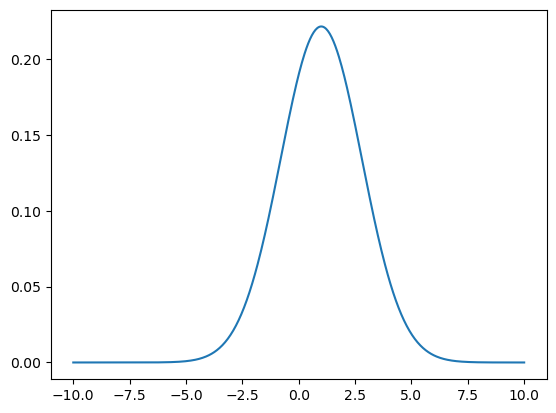

In [11]:
x = np.linspace(-10, 10, 500)
x = torch.tensor(x)
plt.plot(x, [1/(np.sqrt(3.24*2*np.pi)) * np.exp(-(xi-1)**2/(2*3.24)) for xi in x])

In [12]:
get_mixture_pdf([0,0], 'b', output_dist)

import sympy
x = sympy.Symbol('x')
sigma = sympy.Symbol('sigma')
mu = sympy.Symbol('mu')
#y is the pdf of the normal distribution
y = 1/(sigma*sympy.sqrt(2*sympy.pi)) * sympy.exp(-(x-mu)**2/(2*sigma**2))

2.468182534895145e-05 * N( [30.0] ,  [[0.]] )
1.082541397589407e-06 * N( [30.0] ,  [[0.]] )
0.05787824140927299 * N( [9.0] ,  [[4.]] )
0.10996870657183229 * N( [9.0] ,  [[5.29]] )
0.001446884193911372 * N( [-8.0] ,  [[345.96]] )
0.070177235999656 * N( [-2.3000000000000007] ,  [[9.61]] )
0.05788420680898435 * N( [9.0] ,  [[4.]] )
0.10998004083622026 * N( [9.0] ,  [[5.29]] )
0.0014470333214996087 * N( [-8.0] ,  [[345.96]] )
0.07018446903323103 * N( [-2.3000000000000007] ,  [[9.61]] )
0.057884206809005224 * N( [9.0] ,  [[4.]] )
0.10998004083625991 * N( [9.0] ,  [[5.29]] )
0.0014470333215001305 * N( [-8.0] ,  [[345.96]] )
0.07018446903325633 * N( [-2.3000000000000007] ,  [[9.61]] )
0.057884206809005224 * N( [9.0] ,  [[4.]] )
0.10998004083625991 * N( [9.0] ,  [[5.29]] )
0.0014470333215001305 * N( [-8.0] ,  [[345.96]] )
0.07018446903325633 * N( [-2.3000000000000007] ,  [[9.61]] )
0.0025385315494047627 * N( [9.0] ,  [[4.]] )
0.004823212044502541 * N( [9.0] ,  [[5.29]] )
6.346013778488149e-05 

In [13]:
print(output_dist.gm.pi)
print(output_dist.gm.mu)
print(output_dist.gm.sigma)

[2.468182534895145e-05, 1.082541397589407e-06, 0.05787824140927299, 0.10996870657183229, 0.001446884193911372, 0.070177235999656, 0.05788420680898435, 0.10998004083622026, 0.0014470333214996087, 0.07018446903323103, 0.057884206809005224, 0.10998004083625991, 0.0014470333215001305, 0.07018446903325633, 0.057884206809005224, 0.10998004083625991, 0.0014470333215001305, 0.07018446903325633, 0.0025385315494047627, 0.004823212044502541, 6.346013778488149e-05, 0.003077963726911173, 0.0025387931909993133, 0.004823709163748696, 6.346667849998285e-05, 0.003078280966749168, 0.0025387931910002288, 0.004823709163750435, 6.346667850000574e-05, 0.003078280966750278, 0.0025387931910002288, 0.004823709163750435, 6.346667850000574e-05, 0.003078280966750278]
[array([ 1., 30.]), array([10.5, 30. ]), array([1., 9.]), array([1., 9.]), array([ 1., -8.]), array([ 1. , -2.3]), array([1., 9.]), array([1., 9.]), array([ 1., -8.]), array([ 1. , -2.3]), array([1., 9.]), array([1., 9.]), array([ 1., -8.]), array([ 

In [14]:
#utils.create_histogram(data, ['skill1', 'skill2', 'p1wins'])
#data_program = utils.sample_gmm(output_dist, 500)
#take first, second and last column of data
#data_program = data_program[:, [0, 1, 3]]

#utils.create_histogram(data_program, ['skill1', 'skill2', 'p1wins'])

print(output_dist.gm.pi)
print(output_dist.gm.mu)
print(output_dist.gm.sigma)

[2.468182534895145e-05, 1.082541397589407e-06, 0.05787824140927299, 0.10996870657183229, 0.001446884193911372, 0.070177235999656, 0.05788420680898435, 0.10998004083622026, 0.0014470333214996087, 0.07018446903323103, 0.057884206809005224, 0.10998004083625991, 0.0014470333215001305, 0.07018446903325633, 0.057884206809005224, 0.10998004083625991, 0.0014470333215001305, 0.07018446903325633, 0.0025385315494047627, 0.004823212044502541, 6.346013778488149e-05, 0.003077963726911173, 0.0025387931909993133, 0.004823709163748696, 6.346667849998285e-05, 0.003078280966749168, 0.0025387931910002288, 0.004823709163750435, 6.346667850000574e-05, 0.003078280966750278, 0.0025387931910002288, 0.004823709163750435, 6.346667850000574e-05, 0.003078280966750278]
[array([ 1., 30.]), array([10.5, 30. ]), array([1., 9.]), array([1., 9.]), array([ 1., -8.]), array([ 1. , -2.3]), array([1., 9.]), array([1., 9.]), array([ 1., -8.]), array([ 1. , -2.3]), array([1., 9.]), array([1., 9.]), array([ 1., -8.]), array([ 

/var/folders/wj/s0d4084s7rz93njmy26_wwnw0000gn/T/ipykernel_38100/1477318010.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = matplotlib.cm.get_cmap('Greens')


[]

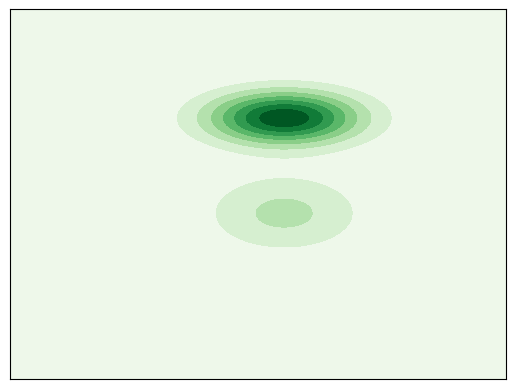

In [15]:
#3D image of the joint distribution
from mpl_toolkits.mplot3d import Axes3D
def get_mixture_pdf(point, data_var_list = data_var_list):
    pdf = np.zeros([point.shape[0], point.shape[1]])
    indexes = {element: [index for index, value in enumerate(output_dist.var_list) if value == element] for element in data_var_list}
    for i in range(output_dist.gm.n_comp()):
        marginal_means = []
        covariance_index = []
        for element, index_list in indexes.items():
            marginal_means.append(output_dist.gm.mu[i][index_list][0])
            covariance_index.append(index_list[0])

        marginal_covariance_matrix = output_dist.gm.sigma[i][np.ix_(covariance_index,covariance_index)]
        for j in range(point.shape[0]):
            for k in range(point.shape[1]):
                try:
                    pdf[j][k]+= output_dist.gm.pi[i] * multivariate_normal.pdf(point[j][k], mean = marginal_means, cov = marginal_covariance_matrix, allow_singular=True)
                except:
                    pdf[j][k]+= 0
    return pdf
        
color_map = matplotlib.cm.get_cmap('Greens')
vars_to_plot = ['a', 'b']
idx1 = output_dist.var_list.index(vars_to_plot[0])
mean1 = output_dist.gm.mean()[idx1]
std1= np.sqrt(output_dist.gm.cov()[idx1, idx1])
idx2 = output_dist.var_list.index(vars_to_plot[1])
mean2 = output_dist.gm.mean()[idx2]
std2= np.sqrt(output_dist.gm.cov()[idx2, idx2])
x1 = min(int(mean1-std1), int(np.min([data_point[data_var_list.index(vars_to_plot[0])] for data_point in data])))
x2 = max(int(mean1+std1), int(np.max([data_point[data_var_list.index(vars_to_plot[0])] for data_point in data])) )
y1 = min(int(mean2-std2), int(np.min([data_point[data_var_list.index(vars_to_plot[1])] for data_point in data])) )
y2 = max(int(mean2+std2), int(np.max([data_point[data_var_list.index(vars_to_plot[1])] for data_point in data])) )
x1 = -10
x2 = 10
y1 = -22
y2 = 22
x, y = np.mgrid[x1:x2:.1, y1:y2:.1]
pos = np.dstack((x, y))
#rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])
fig2 = plt.figure()
ax2 = fig2.add_subplot(111)
ax2.contourf(x, y, get_mixture_pdf(pos, vars_to_plot), cmap=color_map)
#ax2.scatter([pair[data_var_list.index(vars_to_plot[0])] for pair in data], [pair[data_var_list.index(vars_to_plot[1])] for pair in data], color = 'red', alpha = 0.7, s = 0.8, label = 'Data')
#ax2.set_title("Joint Distribution of the generated program")
#ax2.set_xlabel(vars_to_plot[0])
#ax2.set_ylabel(vars_to_plot[1])
#ax2.spines['right'].set_visible(False)
#ax2.spines['top'].set_visible(False)
ax2.set_xticks([])
ax2.set_yticks([])
#ax2.grid(True)
#ax2.legend(loc = 'lower right')